# Training a stack of layers using CTC loss

## Imports and housekeeping

In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rockpool imports
from rockpool import TSContinuous

# -  Other imports
import numpy as np
from tqdm.autonotebook import tqdm
from jax import jit
from jax.nn import log_softmax
from jax import numpy as jnp
from jax.lax import scan
from jax import config as jax_config
from jax.nn import log_softmax
import time

from typing import Dict, Tuple, Any, Callable, Union, List, Optional

# - Configure matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300


Params = Union[Dict, Tuple, List]


In [2]:
#### Uncomment next line for debugging jax. It will be super slow.
#jax_config.update('jax_disable_jit', True)

## Define CTC loss function

Just execute the next super large box. It will create the original CTC loss function implemented in Numpy, the Torch version of it, the Jax version of it and the Jax loss function for feedforward stacks.

In [3]:
def ctc_loss_numpy(label, log_prob, seq_length, big_num=1e10):

    label_ = [0, 0]
    l = len(label)
    for i in range(l):
        label_.append(int(label[i]))
        label_.append(0)
        
    l_ = 2 * l + 1
    aa = np.full((seq_length, l_ + 1), -big_num)
    aa[0][1] = log_prob[0][0]
    aa[0][2] = log_prob[0][label_[2]]
    
    for i in range(1, seq_length):
        aa[i][1] = aa[i - 1][1] + log_prob[i][0]
        aa[i][2] = np.logaddexp(aa[i - 1][2], aa[i - 1][1]) + log_prob[i][label_[2]]
        
        for j in range(3, l_ + 1):
            aa[i][j] = np.logaddexp(aa[i - 1][j], aa[i - 1][j - 1])
            
            if label_[j] != 0 and label_[j] != label_[j - 2]:
                aa[i][j] = np.logaddexp(aa[i][j], aa[i - 1][j - 2])
                
            aa[i][j] += log_prob[i][label_[j]]
            
    return -np.logaddexp(aa[seq_length - 1][l_], aa[seq_length - 1][l_ - 1])


def ctc_loss_jax(label, log_prob, seq_length, big_num=1e10):
    
    label_ = jnp.full(2 * len(label) + 2, 0)
    label_ = label_.at[2::2].set(label)
    
    # - Initialise `aa` matrix
    l_ = 2 * len(label) + 1
    
    # append a row zeros to log_prob
    log_prob_ = jnp.full([log_prob.shape[0]+1, log_prob.shape[1]], -big_num)
    log_prob_ = log_prob_.at[:-1, :].set(log_prob)
    
    # aa = np.full((seq_length, l_ + 1), -big_num)
    aa_0 = jnp.full((l_ + 1,), -big_num)

    #     aa[0][1] = log_prob[0][0]
    #     aa[0][2] = log_prob[0][label_[2]]
    aa_0 = aa_0.at[1].set(log_prob_[0, 0])
    aa_0 = aa_0.at[2].set(log_prob_[0, label_[2]])

    # - Pre-index log prob
    log_prob_label = log_prob_[:, label_]
    
    #### Outer loop
    
    # for i in range(1, seq_length):
    def outer(carry, inputs) -> jnp.ndarray:
        (log_prob_i, log_prob_label_i) = inputs
        aa_isub1 = carry
        
        # - Initialise aa_ret_i
        aa_ret_i = jnp.full((l_+1,), -big_num)
        
        # aa[i][1] = aa[i - 1][1] + log_prob[i][0]
        # aa[i][2] = np.logaddexp(aa[i - 1][2], aa[i - 1][1]) + log_prob[i][label_[2]]
        aa_ret_i = aa_ret_i.at[1].set(aa_isub1[1] + log_prob_i[0])
        aa_ret_i = aa_ret_i.at[2].set(jnp.logaddexp(aa_isub1[2], aa_isub1[1]) + log_prob_label_i[2])
       
        #### - Set up for inner loop
        # aa_isub1 = aa[i-1, :]
        # aa_isub1 = aa_isub1
        
        # log_prob_label_i = log_prob_label_i
        
        # for j in range(3, l_ + 1):
        def inner(_, inputs) -> float:
            aa_isub1_j, aa_isub1_jsub1, aa_isub1_jsub2, label__j, label__jsub2 = inputs

            # aa[i][j] = np.logaddexp(aa[i - 1][j], aa[i - 1][j - 1])
            aa_ret_j = jnp.logaddexp(aa_isub1_j, aa_isub1_jsub1)

            # if label_[j] != 0 and label_[j] != label_[j - 2]:
                # aa[i][j] = np.logaddexp(aa[i][j], aa[i - 1][j - 2])

            cond = (label__j != 0) * (label__j != label__jsub2)
            aa_ret_j = (jnp.logaddexp(aa_ret_j, aa_isub1_jsub2) * cond +
                         aa_ret_j * (1 - cond)
                        )

            # aa[i][j] += log_prob[i][label_[j]]
            # Performed outside loop
        
            return None, aa_ret_j
        
        # - Perform inner loop
        j = np.arange(3, l_ + 1)
        inputs = (
            aa_isub1[j],
            aa_isub1[j - 1],
            aa_isub1[j - 2],
            label_[j],
            label_[j - 2],
        )
        _, aa_ret_inner = scan(
            f = inner,
            xs = inputs,
            init = None,
        )
        
        aa_ret_inner += log_prob_label_i[3:l_+1]
        
        #### - end inner loop
        
        # - Assign inner loop results to aa_ret_i
        aa_ret_i = aa_ret_i.at[3:l_+1].set(aa_ret_inner)
    
        # return carry, outputs
        return aa_ret_i, aa_ret_i

    inputs = (
        log_prob_[1:seq_length+1],
        log_prob_label[1:seq_length+1]
    )
    _, aa_final = scan(
        f = outer,
        xs = inputs,
        init = aa_0,
    )
    
    return -jnp.logaddexp(aa_final[seq_length - 2][l_], aa_final[seq_length - 2][l_ - 1])

@jit
def loss_stack_ctc(
    params: List,
    output_batch_t: jnp.ndarray,
    target_batch_t: jnp.ndarray,
    min_tau: float,
    lambda_ctc: float = 1.0,
    reg_tau: float = 10000.0,
    reg_max_tau: float = 1.0,
    reg_l2_rec: float = 1.0,
    reg_diag_weights: float = 1.0,
    reg_bias: float = 1.0
) -> float:
    """
    Loss function for target versus output

    :param List params:                 List of packed parameters from each layer
    :param jnp.ndarray output_batch_t:   Output rasterised time series [TxO]
    :param jnp.ndarray target_batch_t:   Target rasterised time series [TxO]
    :param float min_tau:               Minimum time constant
    :param float lambda_ctc:            Factor when combining loss, on CTC error term. Default: 1.0
    :param float reg_tau:               Factor when combining loss, on minimum time constant limit. Default: 1e5
    :param float reg_max_tau:           Factor when combining loss, on maximum time constant. Default: 1.0
    :param float reg_l2_rec:            Factor when combining loss, on L2-norm term of recurrent weights. Default: 1.
    :param float reg_diag_weights:      Factor when combining loss, on diagonal enties of the recurrent weights. Default: 1.0
    :param float reg_bias:              Factor when combining loss, on biases. Default: 1.0

    :return float: Current loss value
    """
    # - Measure output-target loss
    print("Compiling CTC loss for this specific input sequence length")


    ctc_loss_jax_jit = jit(ctc_loss_jax, static_argnums = 2)

    label = target_batch_t
    log_prob = log_softmax(output_batch_t, axis=1)

    seq_length = len(log_prob)
    
    ctc_loss = lambda_ctc * ctc_loss_jax_jit(label, log_prob, seq_length)


    # - Get loss for tau parameter constraints
    # - Measure recurrent L2 norms
    tau_loss = 0.0
    max_tau_loss = 0.0
    w_res_norm = 0.0
    diag_weights_loss = 0.0
    bias_loss = 0.0

    for layer_params in params:
        tau_loss += reg_tau * jnp.mean(
            jnp.where(
                layer_params["tau"] < min_tau,
                jnp.exp(-(layer_params["tau"] - min_tau)),
                0,
            )
        )
        w_res_norm += reg_l2_rec * jnp.mean(layer_params["w_recurrent"] ** 2)

        # punish high time constants
        max_tau_loss += reg_max_tau * \
            jnp.max(jnp.clip(layer_params["tau"] - min_tau, 0, jnp.inf) ** 2)

        # punish large biases
        bias_loss += reg_bias * jnp.mean(layer_params['bias'] ** 2)

    # - Loss: target/output squared error, time constant constraint, recurrent weights norm, activation penalty
    fLoss = ctc_loss + tau_loss + w_res_norm + \
        max_tau_loss + bias_loss

    # - Return loss
    return fLoss



def torch_ctc_loss(label, log_prob, seq_length, big_num=1e10):

    def my_log1p(x):
        if (torch.isinf(x) and x > 0):
            return x
        else:
            u = 1. + x
            d = u - 1.
            if d == 0: 
                return x
            else:
                return torch.log(u) * x / d

    def my_log_add_exp(x, y):
        if x == y:
            return x + my_log1p(torch.Tensor([2]))
        tmp = x - y
        if (tmp > 0):
            return x + my_log1p(torch.exp(-tmp))

        if (tmp <= 0):
            return y + my_log1p(torch.exp(tmp))
        
        return tmp

    label_ = [0, 0]

    l = len(label)
    for i in range(l):
        label_.append(int(label[i]))
        label_.append(0)

    l_ = 2 * l + 1
    aa = torch.full((seq_length, l_ + 1), -big_num)
    aa[0][1] = log_prob[0][0]
    aa[0][2] = log_prob[0][label_[2]]
    for i in range(1, seq_length):
        aa[i][1] = aa[i - 1][1] + log_prob[i][0]
        aa[i][2] = my_log_add_exp(aa[i - 1][2], aa[i - 1][1]) + log_prob[i][label_[2]]
        for j in range(3, l_ + 1):
            aa[i][j] = my_log_add_exp(aa[i - 1][j], aa[i - 1][j - 1])
            if label_[j] != 0 and label_[j] != label_[j - 2]:
                aa[i][j] = my_log_add_exp(aa[i][j], aa[i - 1][j - 2])
            aa[i][j] += log_prob[i][label_[j]]

    return -my_log_add_exp(aa[seq_length - 1][l_], aa[seq_length - 1][l_ - 1])


## Define input and targets

This is a very easy task to show that the CTC loss is working.

There are three different tokens (1, 2 and 3) which occur in sequences of varying length. I.e [1, 1, 3, 2] or [3, 2, 3] or [1].
The tokens in the sequence are presented to the network at random times within one trial. Each token has its own input channel.
The task for the network is to find out *which* sequence was presented. As a by-product the network should also learn *when* each token was presented within the trial.



In [4]:
num_tokens = 3 
max_seq_len = 5

duration = 1.0
duration_stim = 0.05
dt = 0.001

time_base_stim = np.arange(0, duration_stim, dt)

def generate_random_input():
    num_stims = np.random.randint(max_seq_len) + 1
    seq = np.random.randint(num_tokens, size=num_stims) + 1
    
    stim_times = np.sort(np.random.choice(np.arange(0, duration - duration_stim, 2*duration_stim), 
                                          num_stims, 
                                          replace=False))

    inp = np.zeros([int(duration/dt), num_tokens])

    for i, t in enumerate(stim_times):
        tmp = np.zeros([len(time_base_stim), num_tokens])
        tmp[:, seq[i]-1] = 1
        inp[int(t / dt): int(t / dt) + len(tmp), :] = tmp 
        
    
    return inp, seq


test sequence [1 3 2 2]


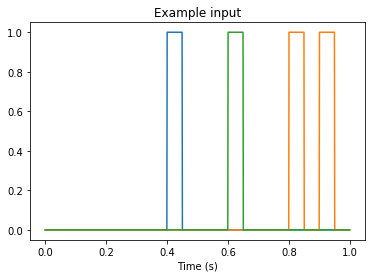

In [5]:
test_inp, test_seq = generate_random_input()

print("test sequence", test_seq)

# - Define a time base for the signal
time_base = np.arange(0, duration, dt)

# - Define a periodic sinusoidal signal
ts_test = TSContinuous(time_base,
                           test_inp, 
                           name = 'Example input')
ts_test.plot()

## Building a Torch model

First, let's use torch to create a model which should be able to solve such tasks using the torch version of CTC.

The network consists of a GRU using 100 units, a linear readout layer and the LogSoftmax layer which is needed for CTC.
The last layer has to be of size $\text{num_tokens} + 1$ as the CTC loss expects the 0th output neuron representing "silence / no-token".

The find the predicted sequence we use the easiest method - the argmax over time while removing consecutives and all '0'.

Let's first train on always the same input sequence, we use the test sequence we created before. This should be SUPER easy. 


In [6]:
layer_sizes = [num_tokens, 1000, num_tokens + 1]

In [7]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
lyr_0 = nn.GRU(input_size=layer_sizes[0], hidden_size=layer_sizes[1], num_layers=1, batch_first=True).to(device)
lyr_1 = nn.Linear(in_features=layer_sizes[1],
                  out_features=layer_sizes[2]).to(device)
lyr_2 = nn.LogSoftmax(dim=1).to(device)
net = nn.Sequential(lyr_0, lyr_1, lyr_2).to(device)

hidden_state = torch.randn(1, 1, layer_sizes[1]).to(device)

optim = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_fn = nn.CTCLoss()

In [9]:
num_trials = 50000
# - Loop over trials
with tqdm(range(num_trials)) as t_:
    for i in t_:
        inp, seq = generate_random_input()
        
        inp_t = torch.Tensor(inp).to(device)
        seq_t = torch.Tensor(seq).type(torch.int).to(device)
        
        feat, hidden_state = lyr_0(inp_t.reshape(1, inp_t.shape[0], inp_t.shape[1]), hidden_state)
        out = lyr_1(feat).squeeze()
        out = lyr_2(out)
        
        # you can switch to our CTC loss implementation by uncommenting the next line 
        # and commenting out the next two lines
        
#         loss = torch_ctc_loss(seq_t.cpu(), out.cpu(), len(out.cpu()))
        pred_seq = out.reshape(len(out), 1, layer_sizes[2])
        loss = loss_fn(pred_seq.cpu(), seq_t.cpu(), (len(out), ), (len(seq_t), ))
        
        
        pred_seq = torch.unique_consecutive(out.argmax(dim=1)).cpu().detach().numpy()
        pred_seq = pred_seq[pred_seq != 0]

        loss.backward()
        optim.step()
        optim.zero_grad()
        hidden_state = hidden_state.detach()
        
        if i % 100 == 0:
            print(f"trial {i} loss {loss.cpu().detach().numpy()} tgt {seq_t.cpu().detach().numpy()} pred {pred_seq}")


trial 0 loss 1379.018310546875 tgt [1] pred [2 3]
trial 100 loss 4.915423393249512 tgt [3] pred []
trial 200 loss 2.729520320892334 tgt [1] pred []
trial 300 loss 1.6265006065368652 tgt [1 2 3 2] pred []
trial 400 loss 1.627259612083435 tgt [1 3 2] pred []
trial 500 loss 1.6290372610092163 tgt [3 3 1 1 2] pred []
trial 600 loss 1.62617826461792 tgt [3 1 1] pred []
trial 700 loss 2.2767364978790283 tgt [1] pred []
trial 800 loss 1.9084933996200562 tgt [3 3 1 1 2] pred []
trial 900 loss 1.7764406204223633 tgt [2 3] pred []
trial 1000 loss 1.8429515361785889 tgt [2 1] pred []
trial 1100 loss 1.741567611694336 tgt [2 3 1 2 3] pred []
trial 1200 loss 1.5577623844146729 tgt [2 1 2 2] pred []
trial 1300 loss 1.6740645170211792 tgt [3 2] pred []
trial 1400 loss 2.403752565383911 tgt [2] pred []
trial 1500 loss 1.6145739555358887 tgt [1 2 1] pred []
trial 1600 loss 1.7684781551361084 tgt [3 3] pred []
trial 1700 loss 1.8273017406463623 tgt [1 1 1 1 2] pred []
trial 1800 loss 1.476692795753479 t

trial 15000 loss 0.6957889199256897 tgt [3] pred []
trial 15100 loss 0.8470104336738586 tgt [1 3] pred []
trial 15200 loss 0.7333892583847046 tgt [3 2 1 2 2] pred []
trial 15300 loss 0.7904424667358398 tgt [2 3] pred []
trial 15400 loss 0.8022214770317078 tgt [3 3 2 3] pred []
trial 15500 loss 0.816851019859314 tgt [3 3 2 3 2] pred []
trial 15600 loss 0.8073484301567078 tgt [3 3 2 3 2] pred []
trial 15700 loss 0.9046354293823242 tgt [2 3 2] pred []
trial 15800 loss 0.7750641703605652 tgt [2 3 2] pred []
trial 15900 loss 0.5549067854881287 tgt [1 1 1 3] pred []
trial 16000 loss 0.6107114553451538 tgt [1 1] pred []
trial 16100 loss 0.9404374361038208 tgt [3 3 2 3 1] pred []
trial 16200 loss 0.9301027655601501 tgt [1] pred []
trial 16300 loss 0.5776235461235046 tgt [2 1 1 1] pred []
trial 16400 loss 0.5005069375038147 tgt [3 3 2 2] pred []
trial 16500 loss 0.914177417755127 tgt [1] pred []
trial 16600 loss 0.6190040707588196 tgt [3] pred []
trial 16700 loss 0.7045018672943115 tgt [1 3 2 3

trial 28700 loss 0.0003538578748703003 tgt [1 2 3 1 1] pred [1 2 3 1 1]
trial 28800 loss 0.00034031274844892323 tgt [3 1] pred [3 1]
trial 28900 loss 9.358456736663356e-05 tgt [2 3 2] pred [2 3 2]
trial 29000 loss 3.195443423464894e-05 tgt [3] pred [3]
trial 29100 loss 7.58401001803577e-05 tgt [3 2 3] pred [3 2 3]
trial 29200 loss 0.00020961891277693212 tgt [3 2 1 3] pred [3 2 1 3]
trial 29300 loss 0.00016861845506355166 tgt [3 1 3 1] pred [3 1 3 1]
trial 29400 loss 0.0005596504197455943 tgt [1] pred [1]
trial 29500 loss 0.00023797492031008005 tgt [3 3] pred [3 3]
trial 29600 loss 0.001154361292719841 tgt [3 3 1 3] pred [3 3 1 3]
trial 29700 loss 0.0016897536115720868 tgt [1 3] pred [1 3]
trial 29800 loss 0.0006281579262576997 tgt [2 3 2] pred [2 3 2]
trial 29900 loss 0.0019369358196854591 tgt [1 2 1] pred [1 2 1]
trial 30000 loss 6.849484634585679e-05 tgt [3 3] pred [3 3]



KeyboardInterrupt: 

This should have worked and found the correct sequence. If not, try executing the box above againg for longer training or re-initialize the model and run again.

Let's see what network does and what the output looks like.

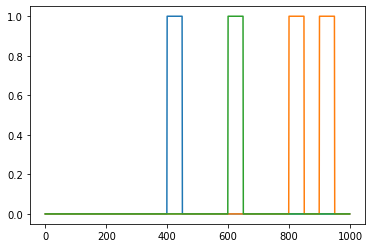

In [10]:
inp_t = torch.Tensor(test_inp).to(device)

feat, hidden_state = lyr_0(inp_t.reshape(1, inp_t.shape[0], inp_t.shape[1]), hidden_state)
out = lyr_1(feat).squeeze()
out = lyr_2(out)

# That's the input, we know that already.
plt.plot(inp_t.cpu().detach().numpy())


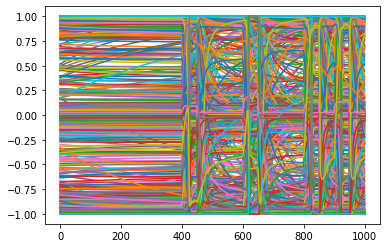

In [11]:
# This is the activity of the recurrent network.
plt.plot(feat.cpu().detach().numpy()[0, :, :])

target [1 3 2 2] prediction [1 3 2 2]


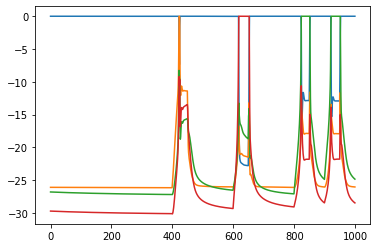

In [15]:
# This is the output of the network.
plt.plot(out.cpu().detach().numpy())


pred_seq = torch.unique_consecutive(out.argmax(dim=1)).cpu().detach().numpy()
pred_seq = pred_seq[pred_seq != 0]

print("target", test_seq, "prediction", pred_seq)

In the plot above, the blue line corresponds to the 0th output neuron which encodes for 'silence / no-token'. The other colors correspond to the other neurons encoding each one token.
As you can see, the output looks as the original paper promised, the 0th output is nearly always most active, while the others are only getting active for very short times.

It seems like it learned the correct sequence. Also the timing of the predicted tokens correlates to the timing of their input.

## Build a feed-forward network

So we saw that a GRU can solve the task.
Let's try a simpler model, a two-layered feed-forward structure using a Sigmoid activation function.

In [21]:
lyr_0 = nn.Linear(in_features=layer_sizes[0],
                  out_features=layer_sizes[1]).to(device)
lyr_1 = nn.Sigmoid()
lyr_2 = nn.Linear(in_features=layer_sizes[1],
                  out_features=layer_sizes[2]).to(device)
lyr_3 = nn.LogSoftmax(dim=1).to(device)

net = nn.Sequential(lyr_0, lyr_1, lyr_2, lyr_3).to(device)

optim = torch.optim.Adam(net.parameters(), lr=1e-5)

loss_fn = nn.CTCLoss()

In [28]:
num_trials = 100000
# - Loop over trials
with tqdm(range(num_trials)) as t_:
    for i in t_:
        inp, seq = generate_random_input()
        
        inp_t = torch.Tensor(inp).to(device)
        seq_t = torch.Tensor(seq).type(torch.int).to(device)

        out = net(inp_t)
        
#         loss = torch_ctc_loss(seq_t.cpu(), out.cpu(), len(out.cpu()))
        pred_seq = out.reshape(len(out), 1, layer_sizes[2])
        loss = loss_fn(pred_seq.cpu(), seq_t.cpu(), (len(out), ), (len(seq_t), ))
        pred_seq = torch.unique_consecutive(out.argmax(dim=1)).cpu().detach().numpy()
        pred_seq = pred_seq[pred_seq != 0]

        loss.backward()
        optim.step()
        optim.zero_grad()
        
        if i % 100 == 0:
            print(f"trial {i} loss {loss.cpu().detach().numpy()} tgt {seq_t.cpu().detach().numpy()} pred {pred_seq}")


trial 0 loss 0.8040339946746826 tgt [3 3 1 2] pred []
trial 100 loss 0.6089208722114563 tgt [2 1 1 1] pred []
trial 200 loss 0.9697927832603455 tgt [3 2] pred []
trial 300 loss 0.6089244484901428 tgt [1 1 1 2] pred []
trial 400 loss 0.9699811935424805 tgt [1] pred []
trial 500 loss 0.8371206521987915 tgt [2 1 1 3 1] pred []
trial 600 loss 0.8040379285812378 tgt [1 3 3 2] pred []
trial 700 loss 0.5485360622406006 tgt [1 1 3 3 3] pred []
trial 800 loss 0.7488420009613037 tgt [2 2 1] pred []
trial 900 loss 0.9697738885879517 tgt [3 2] pred []
trial 1000 loss 0.6089401245117188 tgt [3 3 3 2] pred []
trial 1100 loss 0.9697404503822327 tgt [3 1] pred []
trial 1200 loss 0.9696257710456848 tgt [2 1 2 1 2] pred []
trial 1300 loss 0.8371312022209167 tgt [3 2 3 1 1] pred []
trial 1400 loss 0.837124228477478 tgt [3 1 1 3 2] pred []
trial 1500 loss 0.9697227478027344 tgt [1 3 1] pred []
trial 1600 loss 0.970005989074707 tgt [2] pred []
trial 1700 loss 0.9697661399841309 tgt [3 1] pred []
trial 1800

trial 14900 loss 0.9695188999176025 tgt [3 1 3] pred []
trial 15000 loss 0.6382036805152893 tgt [2 2] pred []
trial 15100 loss 0.8370124101638794 tgt [3 3 2 3 1] pred []
trial 15200 loss 0.969482958316803 tgt [1] pred []
trial 15300 loss 0.9695515632629395 tgt [3 1 2 1 3] pred []
trial 15400 loss 0.8038845658302307 tgt [2 3 3 2] pred []
trial 15500 loss 0.9695510864257812 tgt [1 3 2 3] pred []
trial 15600 loss 0.9695543050765991 tgt [1 2 3 1 2] pred []
trial 15700 loss 0.6382114291191101 tgt [2 2] pred []
trial 15800 loss 0.48851609230041504 tgt [2 2 2] pred []
trial 15900 loss 0.9695343375205994 tgt [2 3 2] pred []
trial 16000 loss 0.704494833946228 tgt [1 1 2 3 3] pred []
trial 16100 loss 0.6382185816764832 tgt [3 3] pred []
trial 16200 loss 0.9694722890853882 tgt [1] pred []
trial 16300 loss 0.9695310592651367 tgt [3 1] pred []
trial 16400 loss 0.9695379137992859 tgt [3 1 2 1 2] pred []
trial 16500 loss 0.6809545159339905 tgt [1 3 3 3 1] pred []
trial 16600 loss 0.7486536502838135 t

trial 29500 loss 0.9694487452507019 tgt [2] pred []
trial 29600 loss 0.9694762825965881 tgt [2 3] pred []
trial 29700 loss 0.8038683533668518 tgt [1 1 3 1] pred []
trial 29800 loss 0.9695063829421997 tgt [2 1] pred []
trial 29900 loss 0.7486512064933777 tgt [1 2 2] pred []
trial 30000 loss 0.9694658517837524 tgt [3] pred []
trial 30100 loss 0.9694673418998718 tgt [3] pred []
trial 30200 loss 0.9694908857345581 tgt [2] pred []
trial 30300 loss 0.9695375561714172 tgt [3 1 2 1] pred []
trial 30400 loss 0.9695405960083008 tgt [1 2 3 2] pred []
trial 30500 loss 0.6381903290748596 tgt [2 2] pred []
trial 30600 loss 0.9695308804512024 tgt [2 1 2 1 3] pred []
trial 30700 loss 0.9695075154304504 tgt [3 2] pred []
trial 30800 loss 0.9695124626159668 tgt [3 1 3] pred []
trial 30900 loss 0.6381868124008179 tgt [2 2] pred []
trial 31000 loss 0.8369949460029602 tgt [2 2 3 2 3] pred []
trial 31100 loss 0.9695230722427368 tgt [1] pred []
trial 31200 loss 0.803865373134613 tgt [2 2 3 1] pred []
trial 3

trial 44200 loss 0.8370286822319031 tgt [3 2 1 2 2] pred []
trial 44300 loss 0.9695324301719666 tgt [1 3 2 3] pred []
trial 44400 loss 0.7486525177955627 tgt [1 1 2] pred []
trial 44500 loss 0.9695281982421875 tgt [1 3] pred []
trial 44600 loss 0.8038699626922607 tgt [1 1 2 3] pred []
trial 44700 loss 0.9695196747779846 tgt [3 1] pred []
trial 44800 loss 0.803872287273407 tgt [2 2 3 2] pred []
trial 44900 loss 0.8038750886917114 tgt [1 1 2 3] pred []
trial 45000 loss 0.8370009660720825 tgt [1 2 2 1 2] pred []
trial 45100 loss 0.6382141709327698 tgt [3 3] pred []
trial 45200 loss 0.9695364832878113 tgt [2 3 2 1 2] pred []
trial 45300 loss 0.9695310592651367 tgt [1 2] pred []
trial 45400 loss 0.7486462593078613 tgt [3 1 1] pred []
trial 45500 loss 0.9695442318916321 tgt [3 2] pred []
trial 45600 loss 0.608759880065918 tgt [1 1 1 3] pred []
trial 45700 loss 0.8038660883903503 tgt [2 3 3 2] pred []
trial 45800 loss 0.9696131348609924 tgt [3] pred []
trial 45900 loss 0.4885137379169464 tgt 

trial 59000 loss 0.748662531375885 tgt [2 2 3] pred []
trial 59100 loss 0.9695232510566711 tgt [3 1] pred []
trial 59200 loss 0.5483749508857727 tgt [1 1 1 2 2] pred []
trial 59300 loss 0.8369987607002258 tgt [2 2 1 3 2] pred []
trial 59400 loss 0.8038545846939087 tgt [3 1 2 2] pred []
trial 59500 loss 0.5144065618515015 tgt [3 3 3 3 1] pred []
trial 59600 loss 0.9695272445678711 tgt [3 1 3 1] pred []
trial 59700 loss 0.8370024561882019 tgt [2 3 3 2 3] pred []
trial 59800 loss 0.6382017731666565 tgt [2 2 3 3] pred []
trial 59900 loss 0.7486529350280762 tgt [1 3 3] pred []
trial 60000 loss 0.9695196151733398 tgt [1] pred []
trial 60100 loss 0.8038614392280579 tgt [1 1 2 1] pred []
trial 60200 loss 0.8370019793510437 tgt [2 3 2 2 1] pred []
trial 60300 loss 0.7486453056335449 tgt [2 2 1] pred []
trial 60400 loss 0.9695339202880859 tgt [3 1 2 1 2] pred []
trial 60500 loss 0.8369946479797363 tgt [2 3 3 1 2] pred []
trial 60600 loss 0.7486462593078613 tgt [1 2 2] pred []
trial 60700 loss 0.

trial 73700 loss 0.6381848454475403 tgt [2 2] pred []
trial 73800 loss 0.8038566708564758 tgt [3 2 2 3] pred []
trial 73900 loss 0.7486401200294495 tgt [3 3 1] pred []
trial 74000 loss 0.9695270657539368 tgt [3 1 3] pred []
trial 74100 loss 0.6809094548225403 tgt [3 1 1 1 2] pred []
trial 74200 loss 0.9695268273353577 tgt [1] pred []
trial 74300 loss 0.9695135951042175 tgt [2 1] pred []
trial 74400 loss 0.9696488976478577 tgt [1] pred []
trial 74500 loss 0.8369945287704468 tgt [1 3 3 2 3] pred []
trial 74600 loss 0.9695202112197876 tgt [3] pred []
trial 74700 loss 0.6087572574615479 tgt [1 1 1 3] pred []
trial 74800 loss 0.8038619160652161 tgt [3 2 1 1] pred []
trial 74900 loss 0.969527542591095 tgt [3] pred []
trial 75000 loss 0.9695147275924683 tgt [1] pred []
trial 75100 loss 0.7486364245414734 tgt [1 3 3] pred []
trial 75200 loss 0.608744204044342 tgt [3 3 3 2] pred []
trial 75300 loss 0.7486564517021179 tgt [2 2 1] pred []
trial 75400 loss 0.9695265293121338 tgt [2 1] pred []
tria

trial 88300 loss 0.400604248046875 tgt [3 3 3 3] pred []
trial 88400 loss 0.9695294499397278 tgt [3 1] pred []
trial 88500 loss 0.9695250391960144 tgt [1 3 2] pred []
trial 88600 loss 0.9695542454719543 tgt [3 1 3 2] pred []
trial 88700 loss 0.7486298680305481 tgt [2 1 1] pred []
trial 88800 loss 0.7044509649276733 tgt [2 2 1 2 2] pred []
trial 88900 loss 0.9695246815681458 tgt [3] pred []
trial 89000 loss 0.7044777870178223 tgt [3 3 2 2 1] pred []
trial 89100 loss 0.7486482262611389 tgt [1 1 3] pred []
trial 89200 loss 0.6809016466140747 tgt [1 2 2 2 3] pred []
trial 89300 loss 0.8038648962974548 tgt [3 3 2 3] pred []
trial 89400 loss 0.9695276021957397 tgt [3 2] pred []
trial 89500 loss 0.9695074558258057 tgt [1 3 1] pred []
trial 89600 loss 0.9695248603820801 tgt [3 1 2] pred []
trial 89700 loss 0.9695227146148682 tgt [2 1 2 3] pred []
trial 89800 loss 0.6809009909629822 tgt [2 3 1 1 1] pred []
trial 89900 loss 0.7486274838447571 tgt [3 3 2] pred []
trial 90000 loss 0.96951973438262

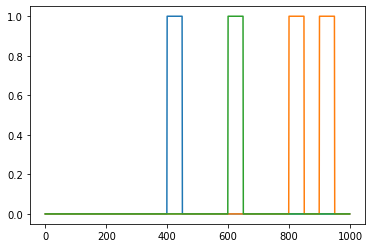

In [26]:
inp_t = torch.Tensor(test_inp).to(device)
out = net(inp_t)

# plot the test input
plt.plot(inp_t.cpu().detach().numpy())

target [1 3 2 2] prediction []


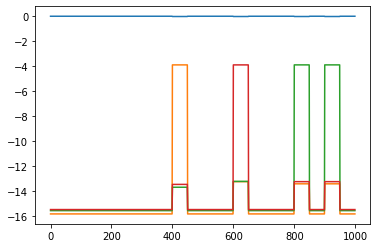

In [27]:
# the output of the FF network
plt.plot(out.cpu().detach().numpy())

pred_seq = torch.unique_consecutive(out.argmax(dim=1)).cpu().detach().numpy()
pred_seq = pred_seq[pred_seq != 0]

print("target", test_seq, "prediction", pred_seq)

As you can see, this feed-forward model is not able to learn the task at all. If you got a lucky initialization, it might look like it learned something, but most of the time the output does not even get close to what it should be. 


## Building a stack

Let's try with a rockpool stack of layers and our implementation of the CTC loss. At least the neurons in rockpool have an internal state. That might help..

In [ ]:
# - Import the individual layer classes
from rockpool.layers import FFRateEulerJax, H_tanh

# - Import the JaxStack network class
from rockpool.networks import JaxStack

In [ ]:
# - Define common layer parameters
tau = 2 * dt
bias = 0.

# - Iterate over layers and construct them into a list
layers = []
for N_in, N_out in zip(layer_sizes[:-1], layer_sizes[1:]):
    # - Generate random parameters for this layer
    weights = np.random.randn(N_in, N_out) / np.sqrt(N_in * N_out)

    # - Build a layer and append it to the list
    layers.append(FFRateEulerJax(weights, tau, bias, activation_func=H_tanh, dt = dt))

In [ ]:
# - Import the JaxStack class
from rockpool.networks import JaxStack

stack_ffwd = JaxStack(layers)
print(stack_ffwd)

## Training the stack

In [ ]:
# removes duplicates in a sequence
def rm_duplicates(tokens):
    res = [tokens[0]]
    for i, token in enumerate(tokens):
        if token == res[-1]: 
            continue
        res.append(tokens[i])
    return np.array(res)

In [ ]:
# - Set the number of total training trials
num_trials = 50000

# - Retain the loss values over epochs
loss_i_t = []
loss_t = []
        
# - Loop over trials
with tqdm(range(num_trials)) as t_:
    for i in t_:
        
        inp, seq = generate_random_input()
        
        # - Randomise the state of all layers before the start of the trial
        stack_ffwd.reset_state()
        stack_ffwd.reset_time()   

        t0 = time.time()
        # - Perform one trial of stochastic back-propagation through time
        l, g, o = stack_ffwd.train_output_target(inp, 
                                                 seq, 
                                                 is_first = i == 1,
                                                 opt_params={'step_size': 1e-4},
                                                 loss_fcn=loss_stack_ctc,
                                                 loss_params={"lambda_ctc": 1.0,
                                                              "reg_tau": 10000.0,
                                                              "reg_max_tau": 10.0,
                                                              "reg_l2_rec": 1.0,
                                                              "reg_bias": 100.,
                                                              "min_tau": 0.015})

        # - Keep the loss values only every 50 trials (since l() takes time to compute)

        if i % 100 == 0:
            out = log_softmax(o()[0]).argmax(axis=1)
            pred_seq = rm_duplicates(out)
            pred_seq = pred_seq[pred_seq != 0]

            loss = l()
            loss_i_t.append(i)
            loss_t.append(loss)
            t_.set_postfix({'loss': loss})

            print(f"trial {i}, loss {loss}, duration {time.time() - t0}, tgt {seq}, pred {pred_seq}")

            assert(loss >= 0)

# - Plot the loss over epochs
plt.plot(loss_i_t, loss_t)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

The model should be able to learn the task. If not, re-execute.

Let's plot the activations and the output.

In [ ]:
stack_ffwd.reset_state()
stack_ffwd.reset_time()

d_outputs = stack_ffwd.evolve(ts_test)

# - Plot each of the layer outputs in turn
for k, out in d_outputs.items():
    plt.figure()
    out.plot()
    plt.title(k)

pred_seq = rm_duplicates(d_outputs['unnamed_0'].samples.argmax(axis=1))
pred_seq = pred_seq[pred_seq != 0]
print(f"target sequence {test_seq} predicted sequence {pred_seq}")

As the GRU in Torch, the rockpool stack was able to predict the sequence correctly and, as can be seen in the output of the network, finds the corresponding stimulation times.

## Final remarks

### Good news
In conclusion, the CTC loss in rockpool / Jax works. Even better, using the same network structure, rockpool can make use of the internal state of neurons to learn a task which Torch was not able to learn.

### Bad news
You might have noticed, that the resolution of the network is very coarse (0.02s). If you try to set it to a finer value (such as 0.001s) the training will get much slower. Even worse, it does not find the solution at all. The problem seems to be inherent to the CTC loss, as not even the GRU model is able to find a solution. 

### Update 
Using much more neurons, actually solve that issue with the large timesteps. But this is unreasonable for this simple task
